In [1]:
## Analyse identified co-eQTLs with decision tree (from initial run)

# Libraries

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from scipy.sparse import issparse

In [3]:
import math

In [4]:
import os

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
import scipy.stats as stats
import numpy as np

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
from sklearn.tree import plot_tree
from sklearn.feature_selection import mutual_info_classif
import pandas as pd 
import numpy as np

In [8]:
import random

In [9]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor 

In [10]:
import seaborn as sns

In [11]:
import gzip

# Parameters

In [12]:
### Define dataset and cell-type for which to analyze

In [13]:
dataset = 'oneK1k'

In [14]:
cell_type = 'CD4_T'

In [15]:
dataset_saved = 'oneK1K'

In [16]:
### Path to the co-EQTL Files

In [17]:
data_path = '../data/current/coeqtl_mapping/co_qtls_sceqtlgen/'

In [18]:
## Path to the meta-data

In [19]:
data_path_meta = '../data/current/meta-data'

In [ ]:
### Path to the calculated summary stats

In [20]:
data_path_summary_stats = '../data/current/summary_stats/'

## Files: Sample_gene_statistic  (info about genes on sample level)
#         Sample_summary (information about samples)
#         Sample_cell statistic

In [21]:
result_path_analysis = "../data/current/coeqtl_mapping/co_qtls_sceqtlgen/analysis_" + dataset + '/' + cell_type + '/' 

In [22]:
## Define the threshold for the p-value based on the number of tests (Bonferroni correction)

In [23]:
p_val_column = 'p_value'
# p_value; q_val

## Use q_val for all other datasets than 1K1K

In [24]:
if p_val_column == 'q_val':
    p_thres = 0.05

if (cell_type ==  'CD4_T') & (p_val_column == 'p_value'):
    p_thres= 0.05/31497753
    
if (cell_type == 'B') & (p_val_column == 'p_value'):
    p_thres = 0.05/39015906  
    
#0.05/31497753   ;  # Bonferonni correction; CD4T
# 0.05/39015906   # Bonferonni correction; B

In [25]:
filter_rb_mt =True   # define whether to filter out ribosomal and mitochondrial genes before training tree

In [26]:
type_sum_stats = 'data' # use expression summary stats based on normalized or raw data

# Data

## Co-EQTL mapping data

In [ ]:
### Load data from the initual co-eQTL mapping

In [27]:
coeQTLs = pd.read_csv(data_path + dataset_saved + "/" + cell_type + "/" + 'F3_decision_tree_input_n.csv')

#F3_decision_tree_input_n

In [28]:
coeQTLs

,Unnamed: 0,cell_type,dataset,feature_id,snp_id,beta,feature_chromosome,feature_end,feature_start,p_value,beta_se,gene2,gene1,amount_tests_datasets,p_val_corrected,p_val_lfdr,q_val
0,1,CD4_T,oneK1K,A1BG-AS1_AASS,19:58355068:G:A,-0.056400,19,58355183,58347751,0.612550,NaN,AASS,A1BG-AS1,31497753,0.991382,0.997565,0.976243
1,2,CD4_T,oneK1K,A1BG-AS1_AASS,7:122023523:T:TTA,-0.050328,7,122144280,122075647,0.651385,NaN,AASS,A1BG-AS1,31497753,0.992673,0.997710,0.977514
2,3,CD4_T,oneK1K,A1BG-AS1_ABCA1,19:58355068:G:A,-0.007532,19,58355183,58347751,0.920512,NaN,ABCA1,A1BG-AS1,31497753,0.998731,1.000000,0.983480
3,4,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104923850:A:G,-0.010463,9,104928237,104781002,0.889754,NaN,ABCA1,A1BG-AS1,31497753,0.998178,1.000000,0.982936
4,5,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104934731:T:C,0.096131,9,104928237,104781002,0.201791,NaN,ABCA1,A1BG-AS1,31497753,0.965108,0.977768,0.950371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497748,31497749,CD4_T,oneK1K,ZXDC_ZYG11B,3:126168798:A:G,-0.037423,3,126475919,126437601,0.242786,NaN,ZYG11B,ZXDC,31497753,0.970158,0.981550,0.955343
31497749,31497750,CD4_T,oneK1K,ZXDC_ZYG11B,3:126479414:ATC:A,-0.028699,3,126475919,126437601,0.370452,NaN,ZYG11B,ZXDC,31497753,0.980444,0.989702,0.965472
31497750,31497751,CD4_T,oneK1K,ZXDC_ZYX,3:126168798:A:G,-0.012530,3,126475919,126437601,0.693168,NaN,ZYX,ZXDC,31497753,0.993743,0.997710,0.978568
31497751,31497752,CD4_T,oneK1K,ZXDC_ZYX,3:126479414:ATC:A,0.039789,3,126475919,126437601,0.210069,NaN,ZYX,ZXDC,31497753,0.966229,0.978784,0.951475


In [29]:
coeQTLs.columns

Index(['Unnamed: 0', 'cell_type', 'dataset', 'feature_id', 'snp_id', 'beta',
       'feature_chromosome', 'feature_end', 'feature_start', 'p_value',
       'beta_se', 'gene2', 'gene1', 'amount_tests_datasets', 'p_val_corrected',
       'p_val_lfdr', 'q_val'],
      dtype='object')

In [30]:
len(pd.unique(coeQTLs['feature_id']))

8648490

In [31]:
### save ordering to later always have the same ordering for the input
ordering = coeQTLs[['feature_id', 'snp_id']]
ordering['seq'] = ordering.index

/tmp/ipykernel_674816/3202930142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordering['seq'] = ordering.index


## Information about eGene/ co-eGenes

In [ ]:
### Load mapping of SNPs to eGenes for initial run

In [32]:
snp_gene_mapping = pd.read_csv(data_path + 'gene_snp_ref.tsv', sep = '\t')

In [33]:
snp_gene_mapping

,gene,snp
0,A1BG-AS1,19:58355068:G:A
1,A1BG,19:58355068:G:A
2,A1BG,19:58357814:C:A
3,A1BG,19:58406208:G:A
4,A1BG,19:58501017:TTTAA:T
...,...,...
12646,ZXDC,3:126168798:A:G
12647,ZXDC,3:126479414:ATC:A
12648,ZYG11B,1:52698548:C:T
12649,ZYX,7:143444382:T:C


In [34]:
snp_gene_mapping['is_egene'] = 1

In [35]:
### Define eGene for all co-egene pairs

In [36]:
coeQTLs = pd.merge(coeQTLs, snp_gene_mapping, left_on = ['snp_id', 'gene1'], right_on = ['snp', 'gene'], how = 'left')

In [37]:
coeQTLs = pd.merge(coeQTLs, snp_gene_mapping, left_on = ['snp_id', 'gene2'], right_on = ['snp', 'gene'], how = 'left')

In [38]:
coeQTLs

,Unnamed: 0,cell_type,dataset,feature_id,snp_id,beta,feature_chromosome,feature_end,feature_start,p_value,...,amount_tests_datasets,p_val_corrected,p_val_lfdr,q_val,gene_x,snp_x,is_egene_x,gene_y,snp_y,is_egene_y
0,1,CD4_T,oneK1K,A1BG-AS1_AASS,19:58355068:G:A,-0.056400,19,58355183,58347751,0.612550,...,31497753,0.991382,0.997565,0.976243,A1BG-AS1,19:58355068:G:A,1.0,NaN,NaN,NaN
1,2,CD4_T,oneK1K,A1BG-AS1_AASS,7:122023523:T:TTA,-0.050328,7,122144280,122075647,0.651385,...,31497753,0.992673,0.997710,0.977514,NaN,NaN,NaN,AASS,7:122023523:T:TTA,1.0
2,3,CD4_T,oneK1K,A1BG-AS1_ABCA1,19:58355068:G:A,-0.007532,19,58355183,58347751,0.920512,...,31497753,0.998731,1.000000,0.983480,A1BG-AS1,19:58355068:G:A,1.0,NaN,NaN,NaN
3,4,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104923850:A:G,-0.010463,9,104928237,104781002,0.889754,...,31497753,0.998178,1.000000,0.982936,NaN,NaN,NaN,ABCA1,9:104923850:A:G,1.0
4,5,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104934731:T:C,0.096131,9,104928237,104781002,0.201791,...,31497753,0.965108,0.977768,0.950371,NaN,NaN,NaN,ABCA1,9:104934731:T:C,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497748,31497749,CD4_T,oneK1K,ZXDC_ZYG11B,3:126168798:A:G,-0.037423,3,126475919,126437601,0.242786,...,31497753,0.970158,0.981550,0.955343,ZXDC,3:126168798:A:G,1.0,NaN,NaN,NaN
31497749,31497750,CD4_T,oneK1K,ZXDC_ZYG11B,3:126479414:ATC:A,-0.028699,3,126475919,126437601,0.370452,...,31497753,0.980444,0.989702,0.965472,ZXDC,3:126479414:ATC:A,1.0,NaN,NaN,NaN
31497750,31497751,CD4_T,oneK1K,ZXDC_ZYX,3:126168798:A:G,-0.012530,3,126475919,126437601,0.693168,...,31497753,0.993743,0.997710,0.978568,ZXDC,3:126168798:A:G,1.0,NaN,NaN,NaN
31497751,31497752,CD4_T,oneK1K,ZXDC_ZYX,3:126479414:ATC:A,0.039789,3,126475919,126437601,0.210069,...,31497753,0.966229,0.978784,0.951475,ZXDC,3:126479414:ATC:A,1.0,NaN,NaN,NaN


In [39]:
coeQTLs['egene'] = ''
coeQTLs['egene'][coeQTLs['is_egene_x'] == 1] = coeQTLs['gene1'][coeQTLs['is_egene_x'] == 1] 
coeQTLs['egene'][coeQTLs['is_egene_y'] == 1] = coeQTLs['gene2'][coeQTLs['is_egene_y'] == 1] 

/tmp/ipykernel_674816/2383517384.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  coeQTLs['egene'][coeQTLs['is_egene_x'] == 1] = coeQTLs['gene1'][coeQTLs['is_egene_x'] == 1]
/tmp/ipykernel_674816/2383517384.py:2: SettingWithCopyWarning: 


In [40]:
len(pd.unique(coeQTLs[(coeQTLs['egene'] == 'RPS26') & ((coeQTLs['q_val'] < 0.05))]['feature_id']))   # short check of correct mapping

610

## Ribosomal and mitochondrial genes

In [ ]:
### Load annotation of ribosomal mitochondrial genes

In [41]:
ribosomal_genes = pd.read_csv(data_path_meta + '/ribosomal_genes.txt.gz', sep = '\t')

In [42]:
ribosomal_genes

,Gene stable ID,Transcript stable ID,Gene name,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Gene Synonym
0,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,OABP
1,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,RLI
2,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,RLI1
3,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,RNASEL1
4,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,RNASELI
...,...,...,...,...,...,...,...
3614,ENSG00000285626,ENST00000649180,5S_rRNA,11561661,11561779,2,NaN
3615,ENSG00000266472,ENST00000614145,MRPS21,150293861,150308979,1,NaN
3616,ENSG00000266472,ENST00000581066,MRPS21,150293861,150308979,1,NaN
3617,ENSG00000285053,ENST00000643410,NaN,235328570,235448952,1,NaN


In [43]:
ribosomal_genes = pd.unique(ribosomal_genes['Gene name'])

In [44]:
#ribosomal_genes

In [45]:
## Optional filter out ribosomal genes

In [46]:
if filter_rb_mt  == True:

    ## New with list of ribosoal gnee-pairs
    coeQTLs = coeQTLs[~coeQTLs['gene1'].isin(ribosomal_genes)]
    coeQTLs = coeQTLs[~coeQTLs['gene2'].isin(ribosomal_genes)]
    

In [48]:
coeQTLs

,Unnamed: 0,cell_type,dataset,feature_id,snp_id,beta,feature_chromosome,feature_end,feature_start,p_value,...,p_val_corrected,p_val_lfdr,q_val,gene_x,snp_x,is_egene_x,gene_y,snp_y,is_egene_y,egene
0,1,CD4_T,oneK1K,A1BG-AS1_AASS,19:58355068:G:A,-0.056400,19,58355183,58347751,0.612550,...,0.991382,0.997565,0.976243,A1BG-AS1,19:58355068:G:A,1.0,NaN,NaN,NaN,A1BG-AS1
1,2,CD4_T,oneK1K,A1BG-AS1_AASS,7:122023523:T:TTA,-0.050328,7,122144280,122075647,0.651385,...,0.992673,0.997710,0.977514,NaN,NaN,NaN,AASS,7:122023523:T:TTA,1.0,AASS
2,3,CD4_T,oneK1K,A1BG-AS1_ABCA1,19:58355068:G:A,-0.007532,19,58355183,58347751,0.920512,...,0.998731,1.000000,0.983480,A1BG-AS1,19:58355068:G:A,1.0,NaN,NaN,NaN,A1BG-AS1
3,4,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104923850:A:G,-0.010463,9,104928237,104781002,0.889754,...,0.998178,1.000000,0.982936,NaN,NaN,NaN,ABCA1,9:104923850:A:G,1.0,ABCA1
4,5,CD4_T,oneK1K,A1BG-AS1_ABCA1,9:104934731:T:C,0.096131,9,104928237,104781002,0.201791,...,0.965108,0.977768,0.950371,NaN,NaN,NaN,ABCA1,9:104934731:T:C,1.0,ABCA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497748,31497749,CD4_T,oneK1K,ZXDC_ZYG11B,3:126168798:A:G,-0.037423,3,126475919,126437601,0.242786,...,0.970158,0.981550,0.955343,ZXDC,3:126168798:A:G,1.0,NaN,NaN,NaN,ZXDC
31497749,31497750,CD4_T,oneK1K,ZXDC_ZYG11B,3:126479414:ATC:A,-0.028699,3,126475919,126437601,0.370452,...,0.980444,0.989702,0.965472,ZXDC,3:126479414:ATC:A,1.0,NaN,NaN,NaN,ZXDC
31497750,31497751,CD4_T,oneK1K,ZXDC_ZYX,3:126168798:A:G,-0.012530,3,126475919,126437601,0.693168,...,0.993743,0.997710,0.978568,ZXDC,3:126168798:A:G,1.0,NaN,NaN,NaN,ZXDC
31497751,31497752,CD4_T,oneK1K,ZXDC_ZYX,3:126479414:ATC:A,0.039789,3,126475919,126437601,0.210069,...,0.966229,0.978784,0.951475,ZXDC,3:126479414:ATC:A,1.0,NaN,NaN,NaN,ZXDC


##  Apply multiple testing correction (identify significant co-eQTLs)

In [49]:
## Define is co-eqtl (true/ false column for prediction)

In [50]:
coeQTLs['is_coeqtl'] = False
coeQTLs['is_coeqtl'][coeQTLs[p_val_column] < p_thres] = True

/tmp/ipykernel_674816/2538178931.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  coeQTLs['is_coeqtl'][coeQTLs[p_val_column] < p_thres] = True
/tmp/ipykernel_674816/2538178931.py:2: SettingWithCopyWarning: 
A value is trying to be set on 

In [51]:
sum(coeQTLs['is_coeqtl'])   # amount of significant co-eqtls

1029

In [52]:
## Only extract relevant columsn

In [53]:
coeQTLs_input = coeQTLs[['feature_id', 'is_coeqtl', 'snp_id', 'is_egene_y', 'is_egene_x']]

In [54]:
coeQTLs_input.shape

(30326351, 5)

In [55]:
len(pd.unique(coeQTLs_input['feature_id']))

8329477

## Summary stats as features

In [ ]:
### Load calculated summary statistics from previous scripts (F6_2-4)

In [56]:
if type_sum_stats == 'data':
    summary_stats = pd.read_csv(result_path_analysis + 'F6_Summary_Stats_all_data.csv')

if type_sum_stats == 'RNA':
    summary_stats = pd.read_csv(result_path_analysis + 'F6_Summary_Stats_all.csv')

In [57]:
summary_stats.shape

(8649759, 44)

In [58]:
summary_stats.columns  # available features

Index(['Unnamed: 0.1', 'gene_pair', 'mean_correlation', 'mean_abs_correlation',
       'var_correlation', 'max_correlation', 'n_NA', 'n_not_NA',
       'n_significant', 'weighted_variance', 'perc_significant',
       'weighted_var_div_mean', 'gene1', 'gene2', 'gene1_Unnamed: 0',
       'gene1_gene', 'gene1_mean_expression',
       'gene1_sd_sample_mean_expression', 'gene1_mean_variance',
       'gene1_sd_sample_variance', 'gene1_sum_non_zero', 'gene1_mean_non_zero',
       'gene1_mean_percentage_zero', 'gene1_sum_zero', 'gene1_mean_zero',
       'gene1_mean_coef_var', 'gene2_Unnamed: 0', 'gene2_gene',
       'gene2_mean_expression', 'gene2_sd_sample_mean_expression',
       'gene2_mean_variance', 'gene2_sd_sample_variance', 'gene2_sum_non_zero',
       'gene2_mean_non_zero', 'gene2_mean_percentage_zero', 'gene2_sum_zero',
       'gene2_mean_zero', 'gene2_mean_coef_var', 'Unnamed: 0', 'n_sample',
       'mean_paired_non_zero', 'mean_paired_zero', 'mean_zero_one_cell',
       'mean_non_z

In [59]:
## filter on features

In [60]:
summary_stats_input = summary_stats

In [61]:
summary_stats_input.shape

(8649759, 44)

## eQTL effect sizes as feature (if available)

In [ ]:
### Load calculated eQTL effect sizes (F6_1)

In [62]:
os.path.exists(result_path_analysis + 'F6_QTL_effects_summary.csv')

True

In [63]:
if os.path.exists(result_path_analysis + 'F6_QTL_effects_summary.csv'):
    eqtl_stats = pd.read_csv(result_path_analysis + 'F6_QTL_effects_summary.csv')
    eqtl_stats['abs_QTL_beta'] = abs(eqtl_stats['QTL_beta'])

# Combine data for input

In [64]:
## Combine to decision tree input

In [65]:
decision_tree_input = pd.merge(coeQTLs_input , summary_stats_input, left_on = 'feature_id', right_on = 'gene_pair')

if os.path.exists(result_path_analysis + 'F6_QTL_effects_summary.csv'):
    decision_tree_input = pd.merge(decision_tree_input ,eqtl_stats  , left_on = ['feature_id', 'snp_id'], right_on = ['feature_id', 'snp_id'])


In [66]:
len(pd.unique(decision_tree_input['feature_id']))   # includes all gene-pairs

8329477

In [67]:
decision_tree_input.shape

(30326351, 54)

In [68]:
decision_tree_input.columns

Index(['feature_id', 'is_coeqtl', 'snp_id', 'is_egene_y', 'is_egene_x',
       'Unnamed: 0.1', 'gene_pair', 'mean_correlation', 'mean_abs_correlation',
       'var_correlation', 'max_correlation', 'n_NA', 'n_not_NA',
       'n_significant', 'weighted_variance', 'perc_significant',
       'weighted_var_div_mean', 'gene1', 'gene2', 'gene1_Unnamed: 0',
       'gene1_gene', 'gene1_mean_expression',
       'gene1_sd_sample_mean_expression', 'gene1_mean_variance',
       'gene1_sd_sample_variance', 'gene1_sum_non_zero', 'gene1_mean_non_zero',
       'gene1_mean_percentage_zero', 'gene1_sum_zero', 'gene1_mean_zero',
       'gene1_mean_coef_var', 'gene2_Unnamed: 0', 'gene2_gene',
       'gene2_mean_expression', 'gene2_sd_sample_mean_expression',
       'gene2_mean_variance', 'gene2_sd_sample_variance', 'gene2_sum_non_zero',
       'gene2_mean_non_zero', 'gene2_mean_percentage_zero', 'gene2_sum_zero',
       'gene2_mean_zero', 'gene2_mean_coef_var', 'Unnamed: 0_x', 'n_sample',
       'mean_pair

In [69]:
decision_tree_input

,feature_id,is_coeqtl,snp_id,is_egene_y,is_egene_x,Unnamed: 0.1,gene_pair,mean_correlation,mean_abs_correlation,var_correlation,...,n_sample,mean_paired_non_zero,mean_paired_zero,mean_zero_one_cell,mean_non_zero_one_cell,Unnamed: 0_y,QTL_beta,QTL_p_value,eGene,abs_QTL_beta
0,A1BG-AS1_AASS,False,19:58355068:G:A,NaN,1.0,5343067,A1BG-AS1_AASS,-0.002946,0.027858,0.001015,...,119.0,0.394958,623.588235,652.344538,29.151261,13295653,-0.151279,1.041730e-05,A1BG-AS1,0.151279
1,A1BG-AS1_AASS,False,7:122023523:T:TTA,1.0,NaN,5343067,A1BG-AS1_AASS,-0.002946,0.027858,0.001015,...,119.0,0.394958,623.588235,652.344538,29.151261,27828902,0.234117,7.686184e-07,AASS,0.234117
2,A1BG-AS1_ABCA1,False,19:58355068:G:A,NaN,1.0,6215473,A1BG-AS1_ABCA1,0.001423,0.031528,0.001636,...,222.0,0.518018,583.229730,615.693694,32.981982,13295656,-0.151279,1.041730e-05,A1BG-AS1,0.151279
3,A1BG-AS1_ABCA1,False,9:104923850:A:G,1.0,NaN,6215473,A1BG-AS1_ABCA1,0.001423,0.031528,0.001636,...,222.0,0.518018,583.229730,615.693694,32.981982,30397885,0.356225,9.063461e-25,ABCA1,0.356225
4,A1BG-AS1_ABCA1,False,9:104934731:T:C,1.0,NaN,6215473,A1BG-AS1_ABCA1,0.001423,0.031528,0.001636,...,222.0,0.518018,583.229730,615.693694,32.981982,30398715,-0.180888,5.532865e-08,ABCA1,0.180888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30326346,ZXDC_ZYG11B,False,3:126168798:A:G,NaN,1.0,1665760,ZXDC_ZYG11B,0.000616,0.038040,0.002456,...,981.0,3.713558,404.164118,480.286442,79.835882,21077292,0.223841,2.670962e-07,ZXDC,0.223841
30326347,ZXDC_ZYG11B,False,3:126479414:ATC:A,NaN,1.0,1665760,ZXDC_ZYG11B,0.000616,0.038040,0.002456,...,981.0,3.713558,404.164118,480.286442,79.835882,21079470,-0.130893,6.205211e-06,ZXDC,0.130893
30326348,ZXDC_ZYX,False,3:126168798:A:G,NaN,1.0,3580023,ZXDC_ZYX,0.001247,0.038562,0.002402,...,999.0,5.670671,388.208208,473.351351,90.813814,21077293,0.223841,2.670962e-07,ZXDC,0.223841
30326349,ZXDC_ZYX,False,3:126479414:ATC:A,NaN,1.0,3580023,ZXDC_ZYX,0.001247,0.038562,0.002402,...,999.0,5.670671,388.208208,473.351351,90.813814,21079471,-0.130893,6.205211e-06,ZXDC,0.130893


In [70]:
### generate combined features

In [71]:
decision_tree_input['mean_expression'] = (decision_tree_input['gene1_mean_expression']  + decision_tree_input['gene2_mean_expression'] )/ 2
decision_tree_input['mean_variance'] = (decision_tree_input['gene1_mean_variance']  + decision_tree_input['gene2_mean_variance'] )/ 2
decision_tree_input['mean_sum_non_zero'] = (decision_tree_input['gene1_sum_non_zero']  + decision_tree_input['gene2_sum_non_zero'] )/ 2
decision_tree_input['mean_mean_percentage_zero'] = (decision_tree_input['gene1_mean_percentage_zero']  + decision_tree_input['gene2_mean_percentage_zero'] )/ 2

In [72]:
decision_tree_input['min_mean_expression'] = decision_tree_input[['gene1_mean_expression','gene2_mean_expression']].min(axis=1)
decision_tree_input['min_mean_variance'] = decision_tree_input[['gene1_mean_variance','gene2_mean_variance']].min(axis=1)
decision_tree_input['min_sum_non_zero'] = decision_tree_input[['gene1_sum_non_zero','gene2_sum_non_zero']].min(axis=1)
decision_tree_input['max_mean_percentage_zero'] = decision_tree_input[[ 'gene1_mean_percentage_zero','gene2_mean_percentage_zero']].max(axis=1)

In [73]:
decision_tree_input['coef_var1'] =  (decision_tree_input['gene1_mean_variance'] / decision_tree_input['gene1_mean_expression'] )
decision_tree_input['coef_var2'] =  (decision_tree_input['gene2_mean_variance'] / decision_tree_input['gene2_mean_expression'] )

In [74]:
decision_tree_input['min_coeff_var'] = decision_tree_input[['coef_var1','coef_var2']].min(axis=1)

In [75]:
#decision_tree_input['min_mean_coeff_var'] = decision_tree_input[['gene1_mean_coef_var','gene2_mean_coef_var']].min(axis=1)

In [76]:
decision_tree_input['mean_expression_e_gene'] = 0
decision_tree_input['mean_expression_e_gene'][decision_tree_input['is_egene_x'] == 1] = decision_tree_input['gene1_mean_expression'][decision_tree_input['is_egene_x'] == 1]
decision_tree_input['mean_expression_e_gene'][decision_tree_input['is_egene_y'] == 1] = decision_tree_input['gene2_mean_expression'][decision_tree_input['is_egene_y'] == 1]

/tmp/ipykernel_674816/983776408.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  decision_tree_input['mean_expression_e_gene'][decision_tree_input['is_egene_x'] == 1] = decision_tree_input['gene1_mean_expression'][decision_tree_input['is_

In [77]:
decision_tree_input['mean_expression_coe_gene'] = 0
decision_tree_input['mean_expression_coe_gene'][decision_tree_input['is_egene_x'] == 1] = decision_tree_input['gene2_mean_expression'][decision_tree_input['is_egene_x'] == 1]
decision_tree_input['mean_expression_coe_gene'][decision_tree_input['is_egene_y'] == 1] = decision_tree_input['gene1_mean_expression'][decision_tree_input['is_egene_y'] == 1]

/tmp/ipykernel_674816/1372922403.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  decision_tree_input['mean_expression_coe_gene'][decision_tree_input['is_egene_x'] == 1] = decision_tree_input['gene2_mean_expression'][decision_tree_input['

In [78]:
#decision_tree_input[['gene1', 'gene2', 'is_coeqtl_x','is_coeqtl_y', 'gene1_mean_expression', 'gene2_mean_expression', 'mean_expression_e_gene', 'mean_expression_coe_gene']]

In [79]:
decision_tree_input.columns

Index(['feature_id', 'is_coeqtl', 'snp_id', 'is_egene_y', 'is_egene_x',
       'Unnamed: 0.1', 'gene_pair', 'mean_correlation', 'mean_abs_correlation',
       'var_correlation', 'max_correlation', 'n_NA', 'n_not_NA',
       'n_significant', 'weighted_variance', 'perc_significant',
       'weighted_var_div_mean', 'gene1', 'gene2', 'gene1_Unnamed: 0',
       'gene1_gene', 'gene1_mean_expression',
       'gene1_sd_sample_mean_expression', 'gene1_mean_variance',
       'gene1_sd_sample_variance', 'gene1_sum_non_zero', 'gene1_mean_non_zero',
       'gene1_mean_percentage_zero', 'gene1_sum_zero', 'gene1_mean_zero',
       'gene1_mean_coef_var', 'gene2_Unnamed: 0', 'gene2_gene',
       'gene2_mean_expression', 'gene2_sd_sample_mean_expression',
       'gene2_mean_variance', 'gene2_sd_sample_variance', 'gene2_sum_non_zero',
       'gene2_mean_non_zero', 'gene2_mean_percentage_zero', 'gene2_sum_zero',
       'gene2_mean_zero', 'gene2_mean_coef_var', 'Unnamed: 0_x', 'n_sample',
       'mean_pair

In [82]:
# backup
decision_tree_data = decision_tree_input

In [83]:
### determine ordering of data
decision_tree_data = pd.merge(decision_tree_data, ordering, left_on=['feature_id', 'snp_id'], right_on=['feature_id', 'snp_id'], how='left')
decision_tree_data = decision_tree_data.sort_values(by = 'seq')

In [84]:
decision_tree_input = decision_tree_data

In [85]:
decision_tree_input.columns

Index(['feature_id', 'is_coeqtl', 'snp_id', 'is_egene_y', 'is_egene_x',
       'Unnamed: 0.1', 'gene_pair', 'mean_correlation', 'mean_abs_correlation',
       'var_correlation', 'max_correlation', 'n_NA', 'n_not_NA',
       'n_significant', 'weighted_variance', 'perc_significant',
       'weighted_var_div_mean', 'gene1', 'gene2', 'gene1_Unnamed: 0',
       'gene1_gene', 'gene1_mean_expression',
       'gene1_sd_sample_mean_expression', 'gene1_mean_variance',
       'gene1_sd_sample_variance', 'gene1_sum_non_zero', 'gene1_mean_non_zero',
       'gene1_mean_percentage_zero', 'gene1_sum_zero', 'gene1_mean_zero',
       'gene1_mean_coef_var', 'gene2_Unnamed: 0', 'gene2_gene',
       'gene2_mean_expression', 'gene2_sd_sample_mean_expression',
       'gene2_mean_variance', 'gene2_sd_sample_variance', 'gene2_sum_non_zero',
       'gene2_mean_non_zero', 'gene2_mean_percentage_zero', 'gene2_sum_zero',
       'gene2_mean_zero', 'gene2_mean_coef_var', 'Unnamed: 0_x', 'n_sample',
       'mean_pair

In [86]:
## select which columns to use as features
features = [ 'is_coeqtl', 
            'mean_abs_correlation', 
            'var_correlation', 'weighted_variance', 'weighted_var_div_mean',
            'n_NA', 'n_not_NA', 'perc_significant',# 'n_significant',  # correlation statistics
             'mean_zero_one_cell', 'mean_paired_zero', 'mean_paired_non_zero',   # paired expression statistics
          #  'gene1_mean_expression',   'gene1_mean_non_zero' , 'gene1_mean_percentage_zero',  'gene1_sum_non_zero','gene1_sum_zero', 'gene1_mean_variance',#'gene1_sd_sample_mean_expression' ,  # single gene statistics
          # 'gene2_mean_expression',   'gene2_mean_non_zero', 'gene2_mean_percentage_zero' , 'gene2_sum_non_zero','gene2_sum_zero',    'gene2_mean_variance',#'gene2_sd_sample_mean_expression',
           #'QTL_beta', 
         #   'abs_QTL_beta' ,# 'QTL_p_value',
           'min_mean_expression', 
         #   'mean_sum_non_zero', 'mean_mean_percentage_zero', 'mean_variance',
         #   'mean_expression',
            'min_mean_variance',#,
            #'min_mean_coeff_var',#,
            'min_sum_non_zero',  
           'mean_expression_coe_gene', 'mean_expression_e_gene',
           'max_mean_percentage_zero' # max mean percentage zero is chosen when using normalized
           ]

In [87]:
decision_tree_input = decision_tree_input[features]

In [88]:
decision_tree_input

,is_coeqtl,mean_abs_correlation,var_correlation,weighted_variance,weighted_var_div_mean,n_NA,n_not_NA,perc_significant,mean_zero_one_cell,mean_paired_zero,mean_paired_non_zero,min_mean_expression,min_mean_variance,min_sum_non_zero,mean_expression_coe_gene,mean_expression_e_gene,max_mean_percentage_zero
0,False,0.027858,0.001015,0.001019,0.036592,935,83,0.036145,652.344538,623.588235,0.394958,0.014451,0.011347,1998,0.014451,0.018659,97.909393
1,False,0.027858,0.001015,0.001019,0.036592,935,83,0.036145,652.344538,623.588235,0.394958,0.014451,0.011347,1998,0.018659,0.014451,97.909393
2,False,0.031528,0.001636,0.001471,0.046654,840,178,0.050562,615.693694,583.229730,0.518018,0.018659,0.013373,5618,0.020130,0.018659,97.191759
3,False,0.031528,0.001636,0.001471,0.046654,840,178,0.050562,615.693694,583.229730,0.518018,0.018659,0.013373,5618,0.018659,0.020130,97.191759
4,False,0.031528,0.001636,0.001471,0.046654,840,178,0.050562,615.693694,583.229730,0.518018,0.018659,0.013373,5618,0.018659,0.020130,97.191759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30326346,False,0.038040,0.002456,0.002108,0.055426,42,976,0.048156,480.286442,404.164118,3.713558,0.050735,0.042380,31706,0.050735,0.077645,93.257399
30326347,False,0.038040,0.002456,0.002108,0.055426,42,976,0.048156,480.286442,404.164118,3.713558,0.050735,0.042380,31706,0.050735,0.077645,93.257399
30326348,False,0.038562,0.002402,0.002066,0.053585,24,994,0.045272,473.351351,388.208208,5.670671,0.067013,0.049110,45821,0.067013,0.077645,90.235386
30326349,False,0.038562,0.002402,0.002066,0.053585,24,994,0.045272,473.351351,388.208208,5.670671,0.067013,0.049110,45821,0.067013,0.077645,90.235386


In [96]:
## Amount co-eQTLs
sum(decision_tree_input['is_coeqtl'])

1029

# Decision Tree (Classification)

## Prepare data & run  model

In [97]:
# Convert the DataFrame to a Bunch object (in this case column 5 was the 'coeqtl' column which contained True, False values to assign whether it is a coeqtl)

metrics=[i for i in range(0,len([i for i in decision_tree_input])) if i !=0]


In [98]:
len(metrics)

16

In [101]:
coeQtls_bunch = Bunch(data= decision_tree_input.iloc[:,metrics].values, target=decision_tree_input.is_coeqtl)

In [102]:
#coeQtls_bunch

In [103]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(coeQtls_bunch.data, coeQtls_bunch.target, test_size=0.2, random_state=42)

In [104]:
X_train

array([[3.98267345e-02, 2.33799186e-03, 2.04881851e-03, ...,
        7.27826129e-01, 4.02455359e-02, 9.45279110e+01],
       [4.10988946e-02, 2.49907734e-03, 2.24982526e-03, ...,
        4.91355554e-02, 8.14926980e-02, 9.24396579e+01],
       [3.34820273e-02, 1.74185531e-03, 1.55599621e-03, ...,
        1.86352276e-02, 1.34483757e-01, 9.69555548e+01],
       ...,
       [3.55778992e-02, 2.10196171e-03, 1.83848454e-03, ...,
        4.19594963e-02, 9.77817926e-02, 9.43204695e+01],
       [3.54268054e-02, 2.00280252e-03, 1.89012913e-03, ...,
        6.70509045e-02, 1.33515101e-02, 9.77630632e+01],
       [3.73066170e-02, 2.16068114e-03, 1.89501573e-03, ...,
        4.78367826e-01, 1.06175252e-01, 8.78950210e+01]])

In [109]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth=1,class_weight={True: 250000, False: 1}, random_state = random.seed(1)) 


In [110]:
# Train the classifier on the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={False: 1, True: 250000}, max_depth=1)

In [111]:
## Importance scores

In [112]:

for i, score in enumerate(clf.feature_importances_):
    print(f"Score: {score:.5f} Feature {metrics[i]}:{decision_tree_input.columns[metrics[i]]}")

Score: 0.00000 Feature 1:mean_abs_correlation
Score: 0.00000 Feature 2:var_correlation
Score: 0.00000 Feature 3:weighted_variance
Score: 0.00000 Feature 4:weighted_var_div_mean
Score: 0.00000 Feature 5:n_NA
Score: 0.00000 Feature 6:n_not_NA
Score: 0.00000 Feature 7:perc_significant
Score: 0.00000 Feature 8:mean_zero_one_cell
Score: 0.00000 Feature 9:mean_paired_zero
Score: 0.00000 Feature 10:mean_paired_non_zero
Score: 0.00000 Feature 11:min_mean_expression
Score: 0.00000 Feature 12:min_mean_variance
Score: 0.00000 Feature 13:min_sum_non_zero
Score: 0.00000 Feature 14:mean_expression_coe_gene
Score: 0.00000 Feature 15:mean_expression_e_gene
Score: 1.00000 Feature 16:max_mean_percentage_zero


In [113]:
clf.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [114]:
len(clf.feature_importances_)

16

## Evaluate for training data

In [115]:
X_train.shape

(24261080, 16)

In [116]:
X_test.shape

(6065271, 16)

In [117]:
# Test the classifier on the training data
y_pred_train = clf.predict(X_train)

In [118]:
# Compute the confusion matrix
cm_train = confusion_matrix(y_train,y_pred_train)

In [119]:
cm_train   # second row: 'true_coeqtls'; first row: 'no_coeqtls'; first column predicted no co-eqtl; second column: predicted co-eqts

array([[12138858, 12121401],
       [       3,      818]])

In [120]:
# Compute the accuracy for each class
accuracies_train = cm_train.diagonal() / cm_train.sum(axis=1)

In [121]:
# Print the accuracies
for i, accuracy in enumerate(accuracies_train):
    print(f"Accuracy for class {i}: {accuracy:.2f}")

Accuracy for class 0: 0.50
Accuracy for class 1: 1.00


In [122]:
## Plot the tree

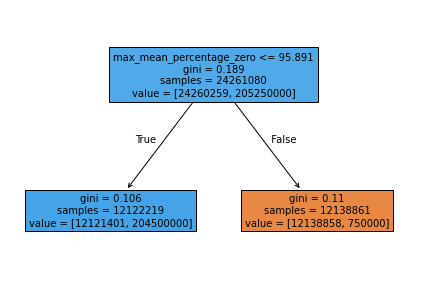

In [126]:
plt.figure(figsize=(7.4,5)) 
plot_tree(clf, fontsize = 10, feature_names = decision_tree_input.columns[metrics], filled = True, proportion  = False)

# Save the plot as a PDF
plt.savefig("figures/F7/F7_decision_tree.pdf", format="pdf", bbox_inches="tight")

In [127]:
## Get the exact thresholds
clf.tree_.threshold


array([95.89076614, -2.        , -2.        ])

## Evaluate for testing data

In [128]:
# Test the classifier on the testing data
y_pred = clf.predict(X_test)

In [129]:
# Compute the accuracy of the classifier's predictions
accuracy = accuracy_score(y_test, y_pred)

In [130]:
# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.50


In [131]:
sum(y_test)

208

In [132]:
sum(y_pred == True)

3030767

In [133]:
sum((y_test == True) & (y_pred == True))

207

In [134]:
# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.50


In [135]:
# Print the information gain
#scores = mutual_info_classif(X_train, y_train)
#for i in range(len(scores)):
#  print(f"Score: {np.round(scores[i],4)} Feature {metrics[i]}: {coeQtls.columns[metrics[i]]}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [136]:
cm

array([[3034503, 3030560],
       [      1,     207]])

In [137]:
# Compute the accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)


In [138]:
# Print the accuracies
for i, accuracy in enumerate(accuracies):
    print(f"Accuracy for class {i}: {accuracy:.2f}")

Accuracy for class 0: 0.50
Accuracy for class 1: 1.00
